# Supervised Learning Final Project

This project is intended to explore the properties of decision tree regressor models. The dataset is adapted from the textbook Machine Learning with R by Brett Lantz.

In [1]:
# https://github.com/y5c/DTSA_5509_Project

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

The below data is a simulated set of 1338 observations of demographic and health data alongside the total healthcare charges billed through insurance for a person during a given year. In the following models, we will develop predictors for medical charges as functions of the other features of the data.

In [3]:
data = pd.read_csv('insurance.csv')

# Treat the following features as categorical, assigning a numeric code to each category
data['sex'] = data['sex'].astype('category').cat.codes
data['smoker'] = data['smoker'].astype('category').cat.codes
data['region'] = data['region'].astype('category').cat.codes

X = data.drop(columns = 'charges')
y = data['charges']

In [4]:
# Wrapper function for saving figures

def save_figure(name):
    plt.savefig(
        name + '.png',
        bbox_inches = 'tight',
        facecolor = 'white',
        transparent = False
        )

Some basic visualizations can help elucidate the nature of the date. In this case, we can observe that the data naturally form two or three clusters, depending on the dimension of interest. Additionally, it is important to note that the data do not contain any strong collinearities. This is convenient, but probably not realistic -- it is another reminder that we are dealing with a simulated dataset.

Note the complex distributions of charges over BMI and age. It is likely that developing a robust predictor will not be trivial.

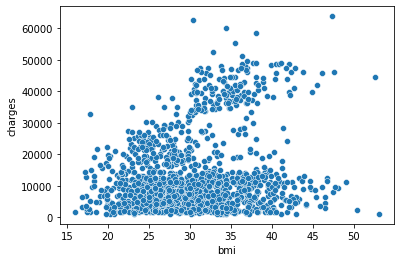

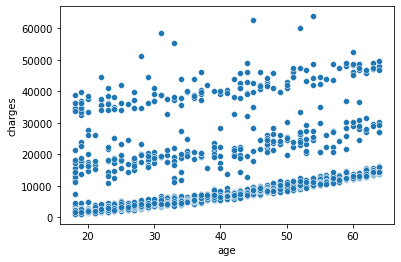

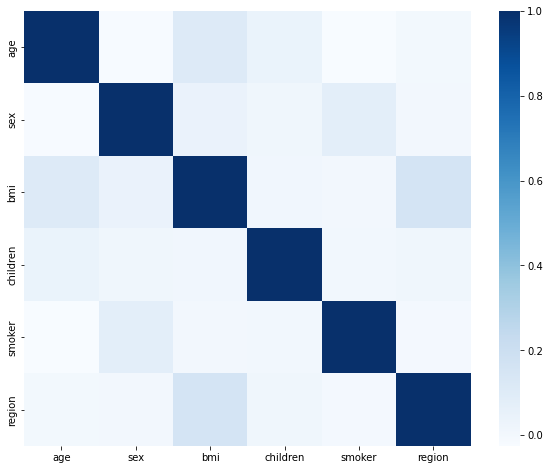

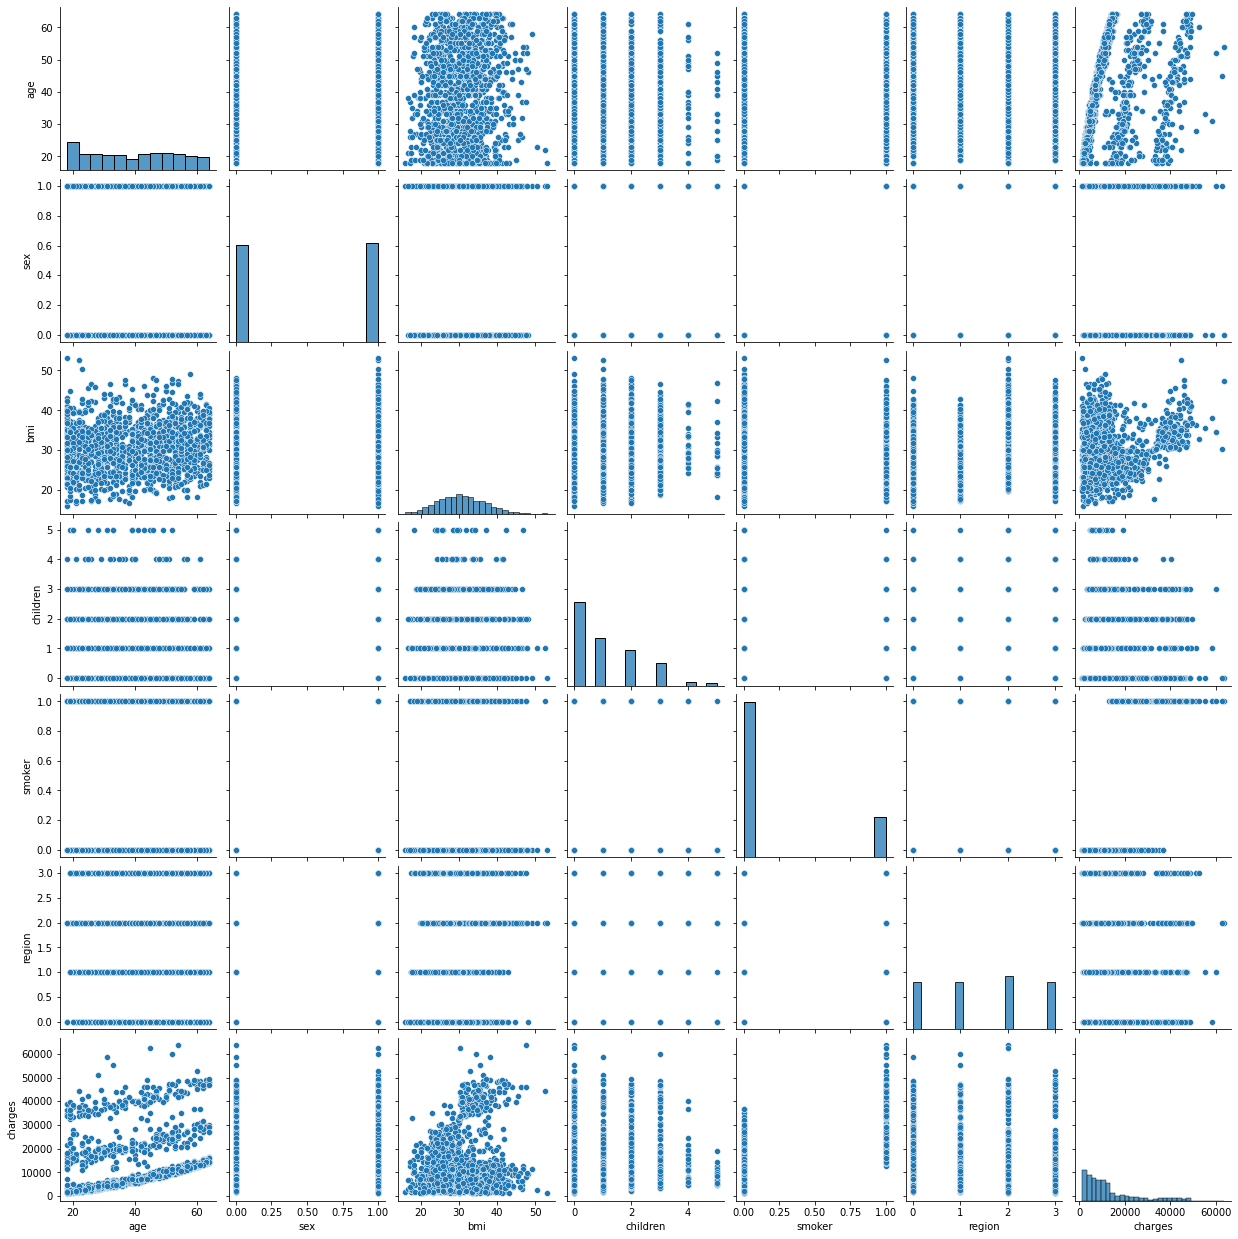

In [5]:
# Summary exploratory visualization

null_check = data.isnull().sum()

plt.figure()
sns.scatterplot(x = data['bmi'], y = data['charges'])
save_figure('scatter_bmi')

plt.figure()
sns.scatterplot(x = data['age'], y = data['charges'])
save_figure('scatter_age')

plt.figure(figsize = (10, 8))
sns.heatmap(X.corr(), cmap = 'Blues')
save_figure('heatmap')

sns.pairplot(data)

To begin, we fit a simple decision tree model to the data. It is interesting to note that cost complexity pruning has no appreciable effect on the accuracy of the model. When the ccp_alpha parameter is included in the grid search, even for very large values, it does not cause pruning beyond the optimal depth of max_depth = 4.

In [6]:
# Decision tree model

dt_params = {
    'max_depth': np.arange(3, 11, 1),
    #'ccp_alpha': np.linspace(0, 0.5)
    }

dt_search = GridSearchCV(
    DecisionTreeRegressor(),
    dt_params,
    cv = 5,
    n_jobs = 8
    )
    
dt_search.fit(X, y)

print(
    'Best parameters: ', dt_search.best_params_, '\n',
    'Best accuracy: ', dt_search.best_score_, '\n',
    'Feature importances: ', dt_search.best_estimator_.feature_importances_
    )

Best parameters:  {'max_depth': 4} 
 Best accuracy:  0.8491272931303661 
 Feature importances:  [0.10717719 0.         0.17123555 0.00618741 0.71373473 0.00166512]


Due to the nature of decision trees, which typically have high variance, an obvious improvement is to consider an ensemble approach. A random forest model should be less sensitive to small changes in the data.

In [7]:
# Random forest model

rf_params = {
    'n_estimators': np.arange(50, 525, 25),
    'max_depth': np.arange(3, 11, 1),
    }

rf_search = GridSearchCV(
    RandomForestRegressor(),
    rf_params,
    cv = 5,
    n_jobs = 8
    )
    
rf_search.fit(X, y)

print(
    'Best parameters: ', rf_search.best_params_, '\n',
    'Best accuracy: ', rf_search.best_score_,
    )

Best parameters:  {'max_depth': 4, 'n_estimators': 325} 
 Best accuracy:  0.8584987135190143


In this case, we can observe that the ensemble method improves on the single predictor with a 10% greater accuracy.

Out of no abundant need for greater predictive power, but rather to satisfy intellectual curiosity, the AdaBoost model is now fit under the same conditions as above.

In [11]:
# AdaBoost model

base_est = [DecisionTreeRegressor(max_depth = n) for n in np.arange(3, 11, 1)]

ab_params = {
    'base_estimator': base_est,
    'n_estimators': np.arange(10, 55, 5),
    'learning_rate': np.linspace(0.01, 0.2),
    }

ab_search = GridSearchCV(
    AdaBoostRegressor(),
    ab_params,
    cv = 5,
    n_jobs = 8
    )

ab_search.fit(X, y)

print(
    'Best parameters: ', ab_search.best_params_, '\n',
    'Best accuracy: ', ab_search.best_score_
    )

Best parameters:  {'base_estimator': DecisionTreeRegressor(max_depth=5), 'learning_rate': 0.03326530612244898, 'n_estimators': 10} 
 Best accuracy:  0.8594022292164075


That the accuracy should be similar to that achieved by the random forest model should not be surprising. What is interesting to note is the power of the model using few (only ten) estimators. This is a reduction by more than a factor of thirty from the number of trees necessary to achieve an r-squared value of 0.86 under the random forest model. At least for this datset, it is clear that boosting, and in particular fitting to residuals, produces a much more efficient model than the relatively naive approach of generating decision trees at random, as in the random forest technique.

The following gradient boosting method may prove an improvement over AdaBoost. By fitting the model to minimize a loss function, in this case through a gradient descent method, the model may more rapidly approach a high degree of accuracy.

In [ ]:
# Gradient boosting model

gb_params = {
    'n_estimators': np.arange(10, 155, 10),
    'learning_rate': np.linspace(0.01, 0.3),
    'max_depth': np.arange(3, 11, 1)
    }

gb_search = GridSearchCV(
    GradientBoostingRegressor(),
    gb_params,
    cv = 5,
    n_jobs = 8
    )

gb_search.fit(X, y)

print(
    'Best parameters: ', gb_search.best_params_, '\n',
    'Best accuracy: ', gb_search.best_score_
    )

The gradient boosting model yields similar results to the AdaBoost and random forest models. This is a very interesting property of well-tuned models -- they tend to perform similarly, at least in the gross, irrespective of the underlying algorithm. Perhaps this subject is beyond the scope of the current investigation.

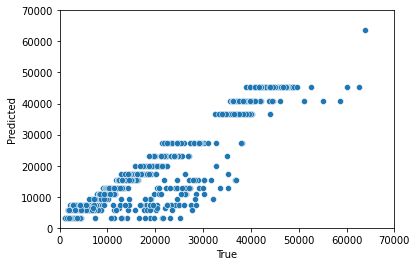

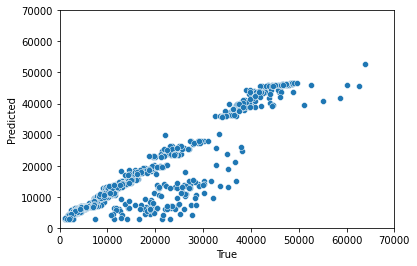

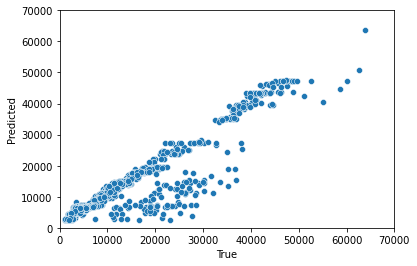

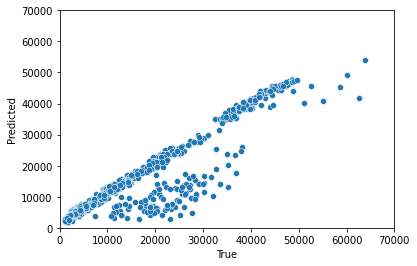

In [10]:
# Generate scatterplots for each model

def plot_scatter(ytrue, yhat, name):
    plt.figure()
    sns.scatterplot(x = ytrue, y = yhat)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.xlim([0, 70000])
    plt.ylim([0, 70000])
    save_figure(name)

dt_yhat = dt_search.best_estimator_.predict(X)
plot_scatter(y, dt_yhat, 'dt_scatter')

rf_yhat = rf_search.best_estimator_.predict(X)
plot_scatter(y, rf_yhat, 'rf_scatter')

ab_yhat = ab_search.best_estimator_.predict(X)
plot_scatter(y, ab_yhat, 'ab_scatter')

gb_yhat = gb_search.best_estimator_.predict(X)
plot_scatter(y, gb_yhat, 'gb_scatter')

Note the clustering of the data. I do not have a way to account for this as yet, but it may be an interesting subject for future studies.

The ensemble models produce more continuum-like (less discrete-appearing) predictions. This accounts for the slight improvement in accuracy over the naive decision tree.

Remaining improvements in model performance are mainly confined to the realm of efficiency on unseen data. They require fewer trees to achieve broadly similar results, although there are subtle differences.

Consider paying attention not only to the average accuracy but also to the variance of the model predictions. One can clearly observe that the gradient boosted model is much less variable than is the random forest model. It is unclear whether this is a valuable improvement in this case, but in some contexts such a reduction in variance may prove vital. The stark differences in variance between models underscores the importance of exploring a variety of models.